In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.io
from scipy import signal

In [2]:
mat = scipy.io.loadmat('PowerValuesOctMay.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Mar 22 19:13:26 2019',
 '__version__': '1.0',
 '__globals__': [],
 'MeasurementsTotal': array([[129.33672838, 134.72952621, 130.95473543, ..., 133.16816453,
         144.20171743, 131.13069585]])}

In [3]:
m = mat['MeasurementsTotal']
m

array([[129.33672838, 134.72952621, 130.95473543, ..., 133.16816453,
        144.20171743, 131.13069585]])

In [4]:
m = np.squeeze(m)

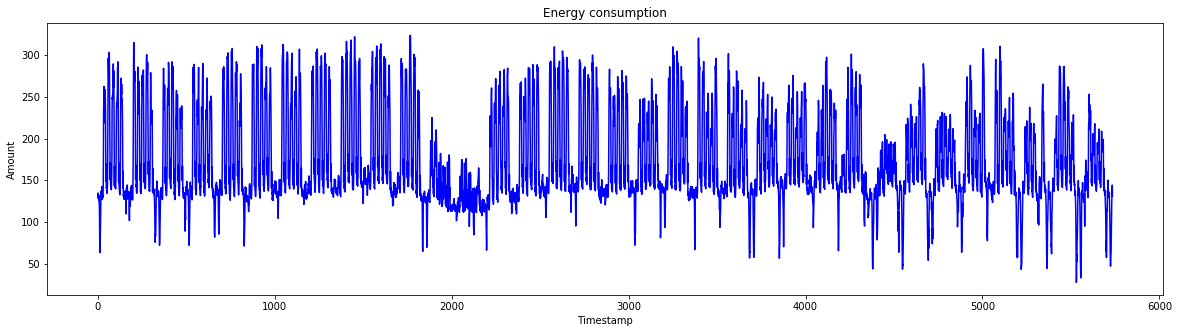

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

ax.plot(m, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Amount')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

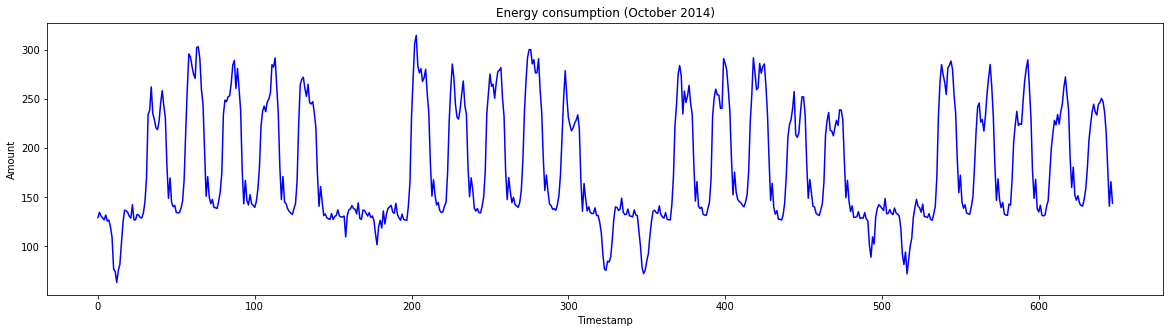

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

ax.plot(m[:27*24], c='b')
ax.set_title('Energy consumption (October 2014)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Amount')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

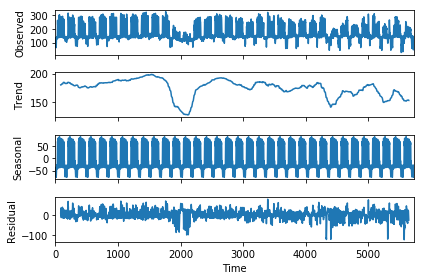

In [7]:
sd = seasonal_decompose(m, model='additive', freq=168)
sd.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

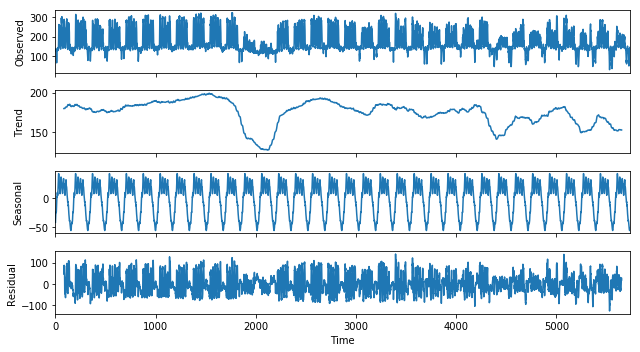

In [8]:
sd = seasonal_decompose(m, model='additive', freq=169)
sd.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

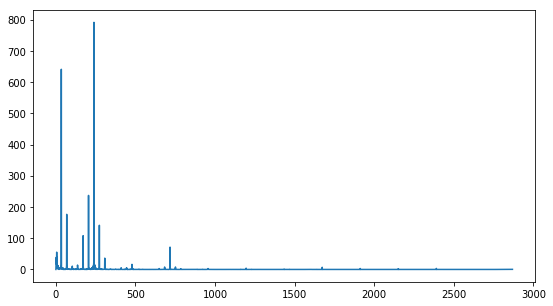

In [9]:
f, Pxx = signal.periodogram(m, scaling='spectrum')
plt.plot(Pxx)

In [10]:
tmp = Pxx.copy()
tmp.sort()
max_values = tmp[-2:]
max_freqs = [list(Pxx).index(v) for v in max_values]
print('Freq1: {:.0f} Freq2: {:.0f}'.format(1/max_freqs[1]*len(m), 1/max_freqs[0]*len(m)))

Freq1: 24 Freq2: 169


### Assume differenced data is iid N(0, $\sigma^2$)

In [11]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(m, order=(0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5736
Model:                     ARMA(0, 1)   Log Likelihood              -28085.454
Method:                       css-mle   S.D. of innovations             32.372
Date:                Fri, 05 Apr 2019   AIC                          56176.907
Time:                        15:29:20   BIC                          56196.871
Sample:                             0   HQIC                         56183.856
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.4303      0.800    217.977      0.000     172.862     175.999
ma.L1.y        0.8723      0.004    204.508      0.000       0.864       0.881
                                    Roots           

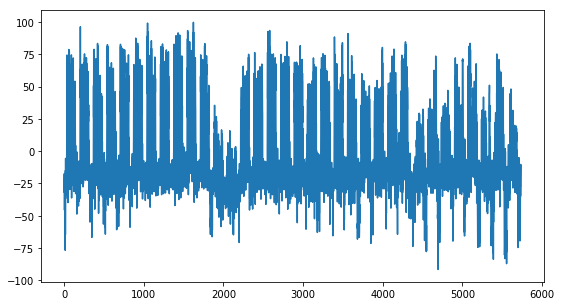

In [12]:
plt.plot(model_fit.resid)